In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import warnings
import numpy as np
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
from lettuce.boundary import EquilibriumBoundaryPU, BounceBackBoundary, HalfwayBounceBackBoundary, FullwayBounceBackBoundary, EquilibriumOutletP, AntiBounceBackOutlet, InterpolatedBounceBackBoundary
from lettuce.flows.cylinder2D import Cylinder2D
from lettuce.flows.obstacleCylinder import ObstacleCylinder

import torch
import time
import datetime
import os
import shutil
from pyevtk.hl import imageToVTK

In [2]:
print("current VRAM (MB): ", torch.cuda.memory_allocated(device="cuda:0")/1024/1024)
print("max. VRAM (MB): ", torch.cuda.max_memory_allocated(device="cuda:0")/1024/1024)

current VRAM (MB):  0.0
max. VRAM (MB):  0.0


In [3]:
### OUTPUT SETTINGS
output_data = False
output_vtk = False  # is overwritten with False if output_data=False (see below)
vtk_fps = 10

# IMPORTANT: set correct output_path, for example "/home/YourUserName/simulation_output"
output_path = "/mnt/ScratchHDD1/Max_Scratch/lbm_simulations"  # lokal HBRS
#output_path = "/home/max/Documents/lbm_simulations"  # lokal Bonn
#output_path = "/home/mbille3s/02_lbm_simulations"  # cluster HBRS

# name: if you want something specific in the dir-name
name = "cyl2D_test"

# choose stencil: "D3Q9" dor 2D, "D3Q15", "D3Q19", "D3Q27" for 3D
stencil_choice = "D2Q9"
# choose collision operator: "bgk, "kbc", "reg"
collision_choice = "bgk"

In [4]:
### SIMULATION PARAMETERS (and estimation of timesteps needed to reach T_target)
re = 200   # Reynoldszahl
Ma = 0.05     # Machzahl
n_steps = 1# 138564    # Schrittzahl
setup_diameter = 1  # D_PU = char_length_pu -> this defines the PU-Reference
flow_velocity = 1  # U_PU = char_velocity_pu -> this defines the PU-Reference velocity (u_max of inflow)

# relative starting point for drag-measurement (make sure periodic state is reached)
periodic_start = 0.9  # relative start of peak_finding for Cd_mean Measurement to cut of any transients

# GEOMETRY
gridpoints_per_diameter = 40 #1  # gp_per_D -> this defines the resolution ( D_LU = GPD)
domain_height_in_D = 50 #5  # D/Y = DpY = diameters per domain width in Y-direction -> this defines the domain-size and total number of Lattice-Nodes
domain_length_in_D = 2*domain_height_in_D  # D/X = domain length in X- / flow-direction
domain_width_in_D = 0  # only for 3D simulation (!)

# RELATION [GPD to DpY] check
# if DpY is even, resulting GPD can't be odd for symmetrical cylinder and channel
# ...if DpY is even, GPD will be corrected to even GPD for symmetrical cylinder
# ...use odd DpY to use odd GPD
gpd_correction=False
if domain_height_in_D % 2 == 0 and gridpoints_per_diameter % 2 != 0:
    gpd_correction = True   # gpd_was_corrected-flag
    gpd_setup = gridpoints_per_diameter   # store old gpd for output
    gridpoints_per_diameter = int(gridpoints_per_diameter/2)*2   # make gpd even
    print("(!) domain_height_in_D is even, gridpoints_per_diameter will be "+str(gridpoints_per_diameter)+". Use odd domain_height_in_D to enable use of odd GPD!")

# SIMULATOR settings
u_init = 1    # initial velocity field: # 0: uniform u=0, # 1: uniform u=1 or parabolic, mean amplitude u_char_lu (similar to poiseuille-flow)
perturb_init = True   # perturb initial symmetry by small sine-wave in initial velocity field -> triggers Karman-vortex street for Re > 46
lateral_walls='periodic'  # type of top/bottom boundary: 'bounceback' = frictious wall, 'periodic' = periodic boundary, 'slip' = non-frictious wall
bc_type='ibb1'  # choose algorithm for bounceback-boundaries: fullway 'fwbb', halfway 'hwbb', linear interpolated 'ibb1'

# T_PU to n_steps estimation: (for example for Re=200 the periodic state is reached for T_PU > 140)
T_target=200
print("shape_LU:", gridpoints_per_diameter*domain_length_in_D, "x", gridpoints_per_diameter*domain_height_in_D)
print("T with", n_steps, "steps:", round(n_steps * (setup_diameter/(gridpoints_per_diameter))*(Ma*1/np.sqrt(3)/flow_velocity),2), "seconds")
print("n_steps to simulate 1 second:", round(((gridpoints_per_diameter)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")
print("n_steps to simulate",T_target,"seconds:",T_target*round(((gridpoints_per_diameter)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")

#exmpl: Re1000,steps25000,ny1000 braucht 43min
#Bonn: Re200, steps200000,gpd20?, 400x200 braucht 10min
#HBRS: Re200, steps100000, gpd20, 800x400 braucht 25min
#Bonn: Re200, steps175000, gpd35, 1330x665 braucht 62,3min

mlups_2060super = 20
mlups_2080ti = 30   # 40 for GPD30,DpY19,nsteps=150000 (steigend mit der Auflösung)

if output_vtk:
    print("generates approx.", int(vtk_fps*(n_steps * (setup_diameter/(gridpoints_per_diameter))*(Ma*1/np.sqrt(3)/flow_velocity)))+1, ".vti/.vtk-frames")

gridpoints = gridpoints_per_diameter**2*domain_length_in_D*domain_height_in_D
print("No. of gridpoints:", gridpoints)
print("estimated min. runtime on 2060super:", round(n_steps*gridpoints/(1e6*mlups_2060super),2), "seconds (", round(n_steps*gridpoints/(1e6*mlups_2060super)/60,2),"minutes )")
print("estimated min. runtime on 2080ti:   ", round(n_steps*gridpoints/(1e6*mlups_2080ti),2), "seconds (", round(n_steps*gridpoints/(1e6*mlups_2080ti)/60,2),"minutes )")

shape_LU: 4000 x 2000
T with 1 steps: 0.0 seconds
n_steps to simulate 1 second: 1385.64 steps
n_steps to simulate 200 seconds: 277128.0 steps
No. of gridpoints: 8000000
estimated min. runtime on 2060super: 0.4 seconds ( 0.01 minutes )
estimated min. runtime on 2080ti:    0.27 seconds ( 0.0 minutes )


In [5]:
### (no user input) CREATE OUTPUT DIRECTORIES
if output_data:  # toggle output
    timestamp = datetime.datetime.now()
    timestamp = timestamp.strftime("%y%m%d")+"_"+timestamp.strftime("%H%M%S")

    dir_name = "/data_" + str(timestamp) + "_" + name + "_" + str(bc_type) + "_GPD" + str(gridpoints_per_diameter) + "_" + str(domain_length_in_D) + "x" + str(domain_height_in_D)
    os.makedirs(output_path+dir_name)
    
    if output_vtk:
        vtk_path = output_path+dir_name+"/vtk/out"
        print("vtk_path: " + vtk_path)
    print("dir_name: "+dir_name)
else:
    output_vtk = False

In [6]:
### SIMULATOR SETUP

# lattice
lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64)
    # stencil, device, dtype
lattice.equilibrium = lt.QuadraticEquilibrium_LessMemory(lattice)

# flow = Cylinder2D(reynolds_number=re, mach_number=Ma,
#                    lattice=lattice,
#                    char_length_pu=setup_diameter,
#                    char_length_lu=gridpoints_per_diameter,
#                    char_velocity_pu=flow_velocity,
#                    y_lu=domain_height_in_D*gridpoints_per_diameter,
#                    x_lu=domain_length_in_D*gridpoints_per_diameter,
#                    lateral_walls=lateral_walls,
#                    bc_type=bc_type,
#                    perturb_init=perturb_init,
#                    u_init=u_init,
#                    radius=gridpoints_per_diameter/2
#                   )

flow = ObstacleCylinder(shape=(domain_length_in_D*gridpoints_per_diameter,
                               domain_height_in_D*gridpoints_per_diameter),
                        reynolds_number=re, mach_number=Ma,
                        lattice=lattice,
                        char_length_pu=setup_diameter,
                        char_length_lu=gridpoints_per_diameter,
                        char_velocity_pu=flow_velocity,
                        lateral_walls=lateral_walls,
                        bc_type=bc_type,
                        perturb_init=perturb_init,
                        u_init=u_init
                        )

# # define a Cylinder-Obstacle (in LU, 1-based!)
# radius_LU = 0.5 * gridpoints_per_diameter
# y_pos_LU = 0.5 * gridpoints_per_diameter * domain_height_in_D + 0.5
# x_pos_LU = y_pos_LU
#
# xyz = tuple(np.linspace(1,n,n) for n in flow.shape)  # Tupel aus Listen indizes (1-n (nicht 0-based!))
# xLU, yLU = np.meshgrid(*xyz, indexing='ij')  # meshgrid aus den x-, y- (und z-)Indizes
#
# condition = np.sqrt((xLU - x_pos_LU) ** 2 + (yLU - y_pos_LU) ** 2) < radius_LU
# flow.obstacle_mask[np.where(condition)] = 1

### simulation object (simulator)
tau = flow.units.relaxation_parameter_lu
re_g = flow.units.characteristic_velocity_lu/(lattice.stencil.cs**2 * (tau-0.5))  # grid reynolds number (should be O(10))

# collision
if collision_choice == "reg":
    collision=lt.RegularizedCollision(lattice, tau)
elif collision_choice == "kbc":
    collision=lt.KBCCollision3D(lattice,tau)
else: # collision_choice = "bgk":
    collision=lt.BGKCollision(lattice, tau)

sim = lt.Simulation(flow, lattice,
                    collision,
                    # lt.BGKCollision(lattice, tau),
                    # lt.RegularizedCollision(lattice, tau),
                    # lt.KBCCollision2D(lattice,tau),
                    lt.StandardStreaming(lattice)
                   )
    # Flow, Lattice-Parameter, KollisionsOperator-Objekt(Parameter), Streaming-Objekt

### Reporter

# VTK Reporter -> Visualisierung
if output_vtk:
    VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(1/vtk_fps)), filename_base=vtk_path)
    sim.reporters.append(VTKreport)
    # export obstacle
    mask_dict = dict()
    mask_dict["mask"] = flow.obstacle_mask[...,None].astype(int)  # extension to pseudo-3D is needed for vtk-export to work
    imageToVTK(
        path=output_path+dir_name+"/vtk/obstacle_point",
        pointData=mask_dict,
    )
    imageToVTK(
        path=output_path+dir_name+"/vtk/obstacle_cell",
        cellData=mask_dict,
    )

# Observable reporter: drag coefficient
DragObservable = lt.DragCoefficient(lattice,flow,sim._boundaries[-1],area=setup_diameter)  # create Observable // ! area A=2*r is in PU
Dragreport = lt.ObservableReporter(DragObservable, out=None)  # create reporter
sim.reporters.append(Dragreport)  # append reporter to list
    
# Observable reporter: lift coefficient
LiftObservable = lt.LiftCoefficient(lattice,flow,sim._boundaries[-1],area=setup_diameter)
Liftreport = lt.ObservableReporter(LiftObservable, out=None)
sim.reporters.append(Liftreport)

IBB initialization took 0.14194154739379883seconds


In [7]:
# TEST CLOCK and AverageVelocity Reporter:

position_1 = flow.x_pos-0.5 + 1.06 * flow.radius * 2  #int(round(flow.x_pos + 1.06 * flow.radius * 2 , 0))
position_2 = flow.x_pos-0.5 + 1.54 * flow.radius * 2  #int(round(flow.x_pos + 1.54 * flow.radius * 2 , 0))
position_3 = flow.x_pos-0.5 + 2.02 * flow.radius * 2  #int(round(flow.x_pos + 2.02 * flow.radius * 2 , 0))
print("V_avg positions:" + "\nposition 1: " + str(position_1) + "\nposition 2: " + str(position_2) + "\nposition 3: " + str(position_3))

# clock
Clock = lt.Clock(lattice)
sim.reporters.append(Clock)

# AvgVelocity
AvgVelocity1 = lt.AverageVelocityReporter(lattice,flow, position_1)
sim.reporters.append(AvgVelocity1)
AvgVelocity2 = lt.AverageVelocityReporter(lattice,flow, position_2)
sim.reporters.append(AvgVelocity2)
AvgVelocity3 = lt.AverageVelocityReporter(lattice,flow, position_3)
sim.reporters.append(AvgVelocity3)

V_avg positions:
position 1: 1042.4
position 2: 1061.6
position 3: 1080.8


In [8]:
### grid reynolds number
print(re_g)

5.000000000000007


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

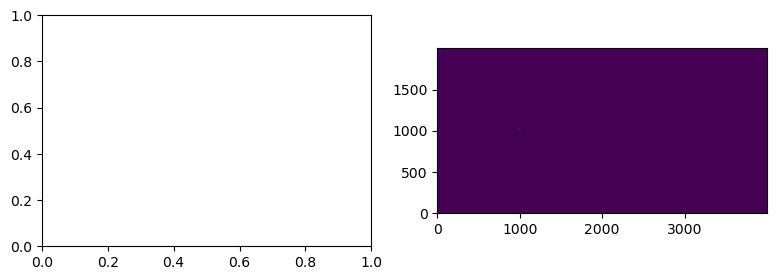

In [9]:
#plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].f_mask[1,190-20:190+20,190-20:190+20]), origin="lower")
#plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].d[7,190-20:190+20,190-20:190+20]), origin="lower")
#plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].d[3].T), origin="lower")
print(sim._boundaries[-1])

fig, axes = plt.subplots(1,2, figsize=(10,3))
fig.subplots_adjust(right=0.85)
# im2 = plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].d[2,190-20:190+20,190-20:190+20].T), origin="lower")
# axes[0].imshow(lattice.convert_to_numpy(sim._boundaries[-1].mask[190-20:190+20,190-20:190+20].T), origin="lower")
im2 = plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].f_mask[4].T), origin="lower")
axes[0].imshow(lattice.convert_to_numpy(sim._boundaries[-1].mask.T), origin="lower")
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

In [ ]:
### export parameters

if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parameters.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###   SIM-Parameters   ###")
    output_file.write("\nRe = "+str(re))
    output_file.write("\nn_steps = "+str(n_steps))
    output_file.write("\nT_target = "+str(flow.units.convert_time_to_pu(n_steps))+" seconds")
    output_file.write("\ngridpoints_per_diameter (gpd) = "+str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\nDpX (D/X) = " + str(domain_length_in_D))
    output_file.write("\nDpY (D/Y) = "+str(domain_height_in_D))
    if lattice.D == 3:
        output_file.write("\nDpZ (D/Z) = "+str(domain_width_in_D))
    output_file.write("\nshape_LU: "+ str(flow.shape))
    output_file.write(("\ntotal_number_of_gridpoints: "+str(lattice.rho(sim.f).numel())))
    output_file.write("\nbc_type = "+str(bc_type))
    output_file.write("\nlateral_walls = "+str(lateral_walls))
    output_file.write("\nstencil = "+str(stencil_choice))
    output_file.write("\ncollision = " + str(collision_choice))
    output_file.write("\n")
    output_file.write("\nMa = " + str(Ma))
    output_file.write("\ntau = " + str(tau))
    output_file.write("\ngrid_reynolds_number (Re_g) = " + str(re_g))
    output_file.write("\n")
    output_file.write("\nsetup_diameter_PU = " + str(setup_diameter))
    output_file.write("\nflow_velocity_PU = " + str(flow_velocity))
    output_file.write("\nu_init = " + str(u_init))
    output_file.write("\nperturb_init = " + str(perturb_init))
    output_file.write("\n")
    output_file.write("\noutput_vtk = " + str(output_vtk))
    output_file.write("\nvtk_fps = " + str(vtk_fps))
    output_file.close()

In [10]:
### calculate and export 2D obstacle_mask as .png
grid_x = gridpoints_per_diameter+2
if output_data:
    output_file = open(output_path+dir_name +"/"+timestamp + "_obstacle_mask_info.txt", "a")
    output_file.write("GPD = " + str(gridpoints_per_diameter)+"\n")
    print("GPD = " + str(gridpoints_per_diameter))
    # define radius and position for a symetrical circular Cylinder-Obstacle
    radius_LU = 0.5 * gridpoints_per_diameter
    y_pos_LU = 0.5 * grid_x + 0.5
    x_pos_LU = y_pos_LU

    # get x,y,z meshgrid of the domain (LU)
    xyz = tuple(np.linspace(1, n, n) for n in (grid_x,grid_x))  # Tupel aus Listen indizes (1-n (nicht 0-based!))
    xLU, yLU = np.meshgrid(*xyz, indexing='ij')  # meshgrid aus den x-, y- (und z-)Indizes -> * damit man die einzelnen Einträge des Tupels übergibt, und nicht das eine Tupel

    # define cylinder (LU)
    obstacle_mast_for_visualization = np.sqrt((xLU - x_pos_LU) ** 2 + (yLU - y_pos_LU) ** 2) < radius_LU

    nx, ny = obstacle_mast_for_visualization.shape  # Anzahl x-Punkte, Anzahl y-Punkte (Skalar), (der gesamten Domain)

    rand_mask = np.zeros((nx, ny), dtype=bool)  # für Randpunkte, die es gibt
    rand_mask_f = np.zeros((lattice.Q, nx, ny), dtype=bool)  # für Randpunkte (inkl. Q-Dimension)
    rand_xq = []  # Liste aller x Werte (inkl. q-multiplizität)
    rand_yq = []  # Liste aller y Werte (inkl. q-multiplizität)

    a, b = np.where(obstacle_mast_for_visualization)  # np.array: Liste der (a) x-Koordinaten  und (b) y-Koordinaten der obstacle_mast_for_visualization
    # ...um über alle Boundary/Objekt/Wand-Knoten iterieren zu können
    for p in range(0, len(a)):  # für alle TRUE-Punkte der obstacle_mast_for_visualization
        for i in range(0, lattice.Q):  # für alle stencil-Richtungen c_i (hier lattice.stencil.e)
            try:  # try in case the neighboring cell does not exist (an f pointing out of the simulation domain)
                if not obstacle_mast_for_visualization[a[p] + lattice.stencil.e[i, 0], b[p] + lattice.stencil.e[i, 1]]:
                    # falls in einer Richtung Punkt+(e_x, e_y; e ist c_i) False ist, ist das also ein Oberflächenpunkt des Objekts (selbst True mit Nachbar False)
                    rand_mask[a[p], b[p]] = 1
                    rand_mask_f[lattice.stencil.opposite[i], a[p], b[p]] = 1
                    rand_xq.append(a[p])
                    rand_yq.append(b[p])
            except IndexError:
                pass  # just ignore this iteration since there is no neighbor there
    rand_x, rand_y = np.where(rand_mask)  # Liste aller Rand-x- und y-Koordinaten
    x_pos = sum(rand_x)/len(rand_x)  # x_Koordinate des Kreis-Zentrums
    y_pos = sum(rand_y)/len(rand_y)  # y-Koordinate des Kreis-Zentrums

    # calculate all radii and r_max and r_min
    r_max = 0
    r_min = gridpoints_per_diameter
    radii = np.zeros_like(rand_x, dtype=float)  # Liste aller Radien (ohne q) in LU
    for p in range(0, len(rand_x)):  # für alle Punkte
        radii[p] = np.sqrt((rand_x[p]-x_pos)**2 + (rand_y[p]-y_pos)**2)  # berechne Abstand des Punktes zum Zentrum
        if radii[p] > r_max:
            r_max = radii[p]
        if radii[p] < r_min:
            r_min = radii[p]

    # calculate all radii (with q-multiplicity)
    radii_q = np.zeros_like(rand_xq, dtype=float)
    for p in range(0, len(rand_xq)):
        radii_q[p] = np.sqrt((rand_xq[p]-x_pos)**2 + (rand_yq[p]-y_pos)**2)

    ### all relative radii in relation to gpd/2
    radii_relative = radii / (radius_LU-0.5)  # (substract 0.5 because "true" boundary location is 0.5LU further out than node-coordinates)
    radii_q_relative = radii_q / (radius_LU-0.5)

    # calc. mean rel_radius
    r_rel_mean = sum(radii_relative)/len(radii_relative)
    rq_rel_mean = sum(radii_q_relative)/len(radii_q_relative)

    ## AREA calculation
    area_theory = np.pi*(gridpoints_per_diameter/2)**2  # area = pi*r² in LU²
    area = len(a)  # area in LU = number of nodes, because every node has a cell of 1LU x 1LU around it

    output_file.write("\nr_rel_mean: " + str(sum(radii_relative)/len(radii_relative)))
    output_file.write("\nrq_rel_mean: " + str(sum(radii_q_relative)/len(radii_q_relative)))
    output_file.write("\nr_rel_min: " + str(r_max/(radius_LU-0.5)))
    output_file.write("\nr_rel_max: " + str(r_min/(radius_LU-0.5)))
    output_file.write("\n\narea_rel: " + str(area/area_theory))
    print("area_rel: " + str(area/area_theory))

    from collections import Counter
    output_file.write("\n\nradii: " + str(Counter(radii)))
    output_file.write("\nradii_q: " + str(Counter(radii_q))+"\n\n")
    output_file.close()

    ### PLOT Mask
    plt.figure()
    plt.imshow(obstacle_mast_for_visualization)
    #plt.xticks(np.arange(gridpoints_per_diameter + 2), minor=True)
    #plt.yticks(np.arange(gridpoints_per_diameter + 2), minor=True)
    ax = plt.gca()
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    if gridpoints_per_diameter >= 10:
        plt.xticks(np.arange(0, xmax, int(xmax/10)))
        plt.yticks(np.arange(0, ymax, int(ymax/10)))
    else:
        plt.xticks(np.arange(0, xmax, 1))
        plt.yticks(np.arange(0, ymax, 1))
    plt.title("GPD = "+str(gridpoints_per_diameter))
    ax.set_xticks(np.arange(-.5, xmax, 1), minor=True)
    ax.set_yticks(np.arange(-.5, ymax, 1), minor=True)
    if gridpoints_per_diameter < 30:
        ax.grid(which="minor", color="k", axis='both', linestyle='-', linewidth=2)
    elif gridpoints_per_diameter < 70:
        ax.grid(which="minor", color="k", axis='both', linestyle='-', linewidth=1)
    elif gridpoints_per_diameter < 100:
        ax.grid(which="minor", color="k", axis='both', linestyle='-', linewidth=0.5)
    elif gridpoints_per_diameter < 150:
        ax.grid(which="minor", color="k", axis='both', linestyle='-', linewidth=0.25)
    plt.savefig(output_path+dir_name +"/"+timestamp + "obtacle_mask_GPD" + str(gridpoints_per_diameter) + ".png")
    #plt.close()

In [13]:
### simple simulation

t_start=time.time()

mlups = sim.step(n_steps) #Simulation mit Schrittzahl n_steps

t_end=time.time()
runtime=t_end-t_start
print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("number of steps:",n_steps)
print("runtime: ",runtime, "seconds (", round(runtime/60,2),"minutes )")

c_time = sim.time_avg["time_collision"]
s_time = sim.time_avg["time_streaming"]
b_time = sim.time_avg["time_boundary"]
r_time = sim.time_avg["time_reporter"]
sum_time = sim.time_avg["time_collision"] + sim.time_avg["time_streaming"] + sim.time_avg["time_boundary"] + sim.time_avg["time_reporter"]

print("collision avg. time:", sim.time_avg["time_collision"], "seconds (" + str(round(100 * c_time/sum_time, 2)) + " %)")
print("streaming avg. time:", sim.time_avg["time_streaming"], "seconds (" + str(round(100 * s_time/sum_time, 2)) + " %)")
print("boundary avg. time:", sim.time_avg["time_boundary"], "seconds (" + str(round(100 * b_time/sum_time, 2)) + " %)")
print("reporter avg. time:", sim.time_avg["time_reporter"], "seconds (" + str(round(100 * r_time/sum_time, 2)) + " %)")

print("current VRAM (MB): ", torch.cuda.memory_allocated(device="cuda:0")/1024/1024)
print("max. VRAM (MB): ", torch.cuda.max_memory_allocated(device="cuda:0")/1024/1024)

MLUPS: 8.811542393576307
PU-Time:  0.0007216878364870324  seconds
number of steps: 1
runtime:  0.9081170558929443 seconds ( 0.02 minutes )
collision avg. time: 0.012055590332844682 seconds (1.33 %)
streaming avg. time: 0.0004894746665134638 seconds (0.05 %)
boundary avg. time: 0.4341098093336768 seconds (47.94 %)
reporter avg. time: 0.45887197866674495 seconds (50.67 %)
current VRAM (MB):  1802.5927734375
max. VRAM (MB):  4621.25732421875


In [17]:
torch.cuda.memory_stats(0)

OrderedDict([('active.all.allocated', 740),
             ('active.all.current', 17),
             ('active.all.freed', 723),
             ('active.all.peak', 26),
             ('active.large_pool.allocated', 402),
             ('active.large_pool.current', 7),
             ('active.large_pool.freed', 395),
             ('active.large_pool.peak', 13),
             ('active.small_pool.allocated', 338),
             ('active.small_pool.current', 10),
             ('active.small_pool.freed', 328),
             ('active.small_pool.peak', 16),
             ('active_bytes.all.allocated', 106909426688),
             ('active_bytes.all.current', 1890155520),
             ('active_bytes.all.freed', 105019271168),
             ('active_bytes.all.peak', 4845739520),
             ('active_bytes.large_pool.allocated', 106902386688),
             ('active_bytes.large_pool.current', 1890150400),
             ('active_bytes.large_pool.freed', 105012236288),
             ('active_bytes.large_pool.peak',

In [13]:
### export stats
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_stats.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###   SIM-STATS  ###")
    output_file.write("\nruntime = "+str(runtime)+ " seconds (="+str(runtime/60)+" minutes)")
    output_file.write("\nMLUPS = "+str(mlups))
    output_file.write("\n")
    output_file.write("\navg. Collision-Time [s] = " + str(c_time) + " (" + str(round(100 * c_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Streaming-Time [s] = " + str(s_time) + " (" + str(round(100 * s_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Boundary-Time  [s] = " + str(b_time) + " (" + str(round(100 * b_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Reporter-Time  [s] = " + str(r_time) + " (" + str(round(100 * r_time/sum_time, 2)) + " %)")
    output_file.write("\n")
    output_file.write("\nVRAM_current [MB] = " + str(torch.cuda.memory_allocated(lattice.device)/1024/1024))
    output_file.write("\nVRAM_peak [MB] = " + str(torch.cuda.max_memory_allocated(lattice.device)/1024/1024))
    output_file.close()

In [13]:
# TEST Clock

print("Clock:")
print(np.array(Clock.out))

Clock:
[[1.00000000e+00 1.44337567e-03]
 [2.00000000e+00 2.88675135e-03]
 [3.00000000e+00 4.33012702e-03]
 ...
 [1.38562000e+05 1.99997020e+02]
 [1.38563000e+05 1.99998463e+02]
 [1.38564000e+05 1.99999907e+02]]


In [14]:
# TEST AvgVelocity Reporter

print("AvgVelocity1")
print(np.array(AvgVelocity1.out))
print(np.array(AvgVelocity1.out).shape)

AvgVelocity1
[[[ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
    1.00000000e+00  1.00000000e+00]
  [-1.20185168e-16 -1.20185168e-16 -1.20185168e-16 ... -1.20185168e-16
   -1.20185168e-16 -1.20185168e-16]]

 [[ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
    1.00000000e+00  1.00000000e+00]
  [ 3.60555504e-16  3.60555504e-16  3.60555504e-16 ...  3.60555504e-16
    3.60555504e-16  3.60555504e-16]]

 [[ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
    1.00000000e+00  1.00000000e+00]
  [-3.60555504e-16 -3.60555504e-16 -3.60555504e-16 ... -3.60555504e-16
   -3.60555504e-16 -3.60555504e-16]]

 ...

 [[ 1.17467800e+00  1.17212913e+00  1.16977511e+00 ...  1.18501878e+00
    1.18125642e+00  1.17771358e+00]
  [-2.76682252e-02 -2.54074927e-02 -2.27175028e-02 ... -3.37194266e-02
   -3.15436776e-02 -2.94671894e-02]]

 [[ 1.17469738e+00  1.17214817e+00  1.16979387e+00 ...  1.18503991e+00
    1.18127704e+00  1.17773358e+00]
  [-2.7549

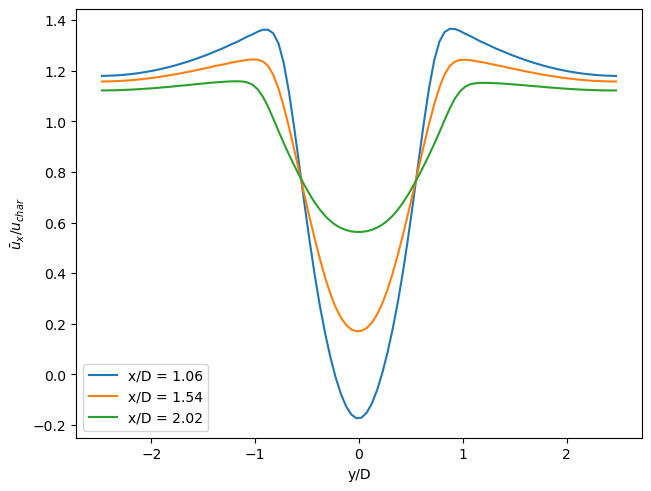

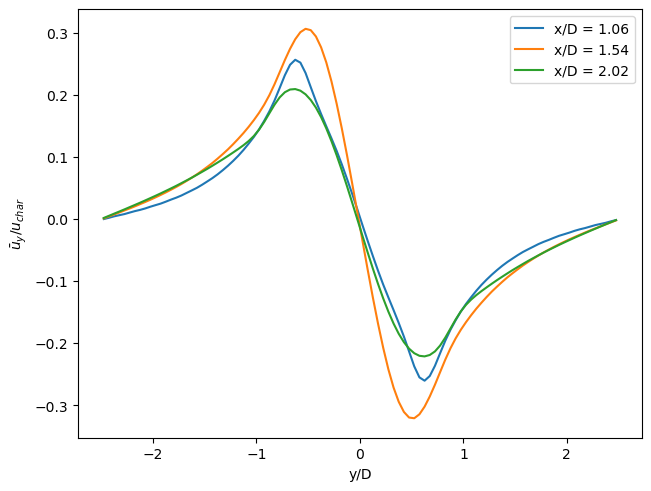

In [15]:
# plot AvgVelocity
avg_u_start = 0.5

if output_data:
    np.save(output_path+dir_name+"/AvgVelocity_1.npy", np.array(AvgVelocity1.out))
    np.save(output_path+dir_name+"/AvgVelocity_2.npy", np.array(AvgVelocity2.out))
    np.save(output_path+dir_name+"/AvgVelocity_3.npy", np.array(AvgVelocity3.out))

avg_u1 = np.array(AvgVelocity1.out)[int(avg_u_start*np.array(AvgVelocity1.out).shape[0]-1):]
avg_u2 = np.array(AvgVelocity2.out)[int(avg_u_start*np.array(AvgVelocity2.out).shape[0]-1):]
avg_u3 = np.array(AvgVelocity3.out)[int(avg_u_start*np.array(AvgVelocity3.out).shape[0]-1):]

avg_u1 = np.mean(avg_u1, axis=0)  # time average
avg_u2 = np.mean(avg_u2, axis=0)  # time average
avg_u3 = np.mean(avg_u3, axis=0)  # time average

avg_u1_x = avg_u1[0]  # u_x component over y
avg_u2_x = avg_u2[0]  # u_x component over y
avg_u3_x = avg_u3[0]  # u_x component over y

avg_u1_y = avg_u1[1]  # u_y component over y
avg_u2_y = avg_u2[1]  # u_y component over y
avg_u3_y = avg_u3[1]  # u_y component over y

y_in_D = (np.arange(avg_u1_x.shape[0])+1-flow.y_pos)/flow.units.characteristic_length_lu  # y/D for figure

# PLOT ux
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(y_in_D,avg_u1_x, y_in_D, avg_u2_x, y_in_D, avg_u3_x)
ax.set_xlabel("y/D")
ax.set_ylabel(r"$\bar{u}_{x}$/$u_{char}$")
ax.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])

# OPT. TO DO: add secondary axis for LU-grid
# ...needs 'function' to convert from y/D in LU and LU in y/D

# OPT. TO DO: make folder for AvgVelocity-stuff
if output_data:
    plt.savefig(output_path+dir_name+"/AvgVelocity_x.png")
plt.show()

# PLOT uy
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(y_in_D,avg_u1_y, y_in_D, avg_u2_y, y_in_D, avg_u3_y)
ax.set_xlabel("y/D")
ax.set_ylabel(r"$\bar{u}_{y}$/$u_{char}$")
ax.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])

# OPT. TO DO: add secondary axis for LU-grid
# ...needs 'function' to convert from y/D in LU and LU in y/D

# OPT. TO DO: make folder for AvgVelocity-stuff

# !!! QUESTION: is x/D the position measured FROM the cylinder (x_pos), or measured from x=0 ?

if output_data:
    plt.savefig(output_path+dir_name+"/AvgVelocity_y.png")
plt.show()

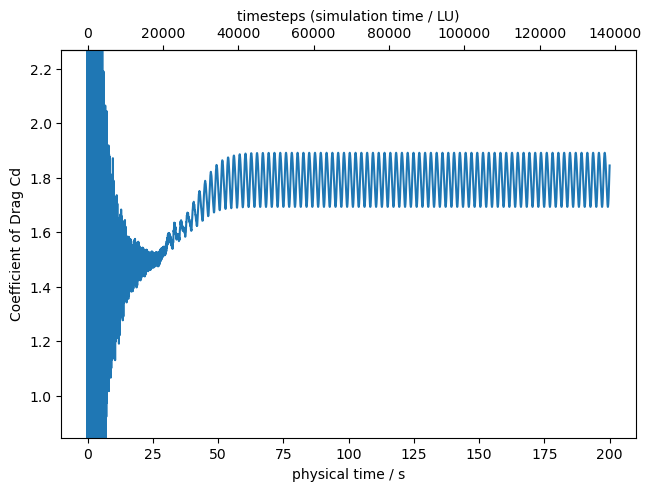

In [33]:
### plot DRAG COEFFICIENT

drag_coefficient = np.array(Dragreport.out)
#print('  stepLU        ', 'timePU        ', 'Cd')
#print(drag_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(drag_coefficient[:,1],drag_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,2])
#ax.set_ylim([1.54,1.545])
#ax.set_xlim([500,600])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/drag_coefficient.png")
    np.savetxt(output_path+dir_name+"/drag_coefficient.txt", drag_coefficient, header="stepLU  |  timePU  |  Cd  FROM str(timestamp)")
ax.set_ylim([drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()*0.5,drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()*1.2])
if output_data:
    plt.savefig(output_path+dir_name+"/drag_coefficient_adjusted.png")
plt.show()

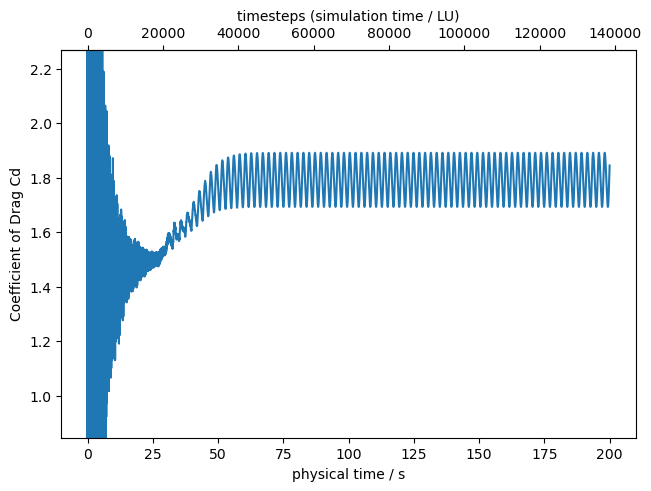

In [31]:
### plot DRAG COEFFICIENT

drag_coefficient = np.array(Dragreport.out)
#print('  stepLU        ', 'timePU        ', 'Cd')
#print(drag_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(drag_coefficient[:,1],drag_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()*0.5,drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()*1.2])
#ax.set_ylim([1.54,1.545])
#ax.set_xlim([500,600])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/drag_coefficient.png")
    np.savetxt(output_path+dir_name+"/drag_coefficient.txt", drag_coefficient, header="stepLU  |  timePU  |  Cd  FROM str(timestamp)")
plt.show()

Cd, simple mean:      1.7941356669979727
Cd, peak_finder mean: 1.7939436097978214
start time of 'mean'-ing: 179.99905004957668


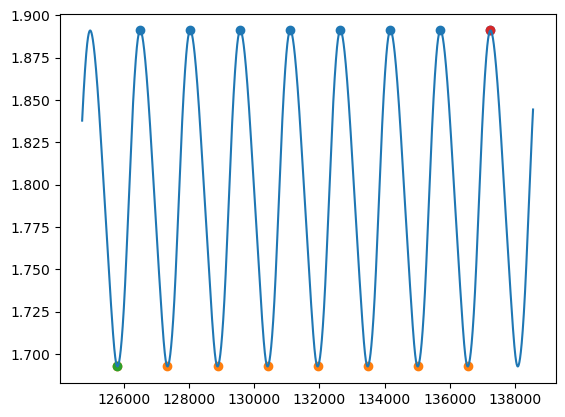

In [17]:
### calculate MEAN DRAG COEFFICIENT in periodic reagion:
try:
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]

    peaks_max = find_peaks(values, prominence=((values.max()-values.min())/2))
    peaks_min = find_peaks(-values, prominence=((values.max()-values.min())/2))
    # find peaks funktioniert hier nicht korrekt, wenn der Drag immernoch ansteigend ist...

    if peaks_min[0].shape[0] - peaks_max[0].shape[0] > 0:
        peak_number = peaks_max[0].shape[0]
    else:
        peak_number = peaks_min[0].shape[0]

    if peaks_min[0][0] < peaks_max[0][0]:
        first_peak = peaks_min[0][0]
        last_peak = peaks_max[0][peak_number-1]
    else:
        first_peak = peaks_max[0][0]
        last_peak = peaks_min[0][peak_number-1]

    drag_mean = values[first_peak:last_peak].mean()
    drag_mean_simple = values.mean()

    print("Cd, simple mean:     ",drag_mean_simple)
    print("Cd, peak_finder mean:",drag_mean)
    print("start time of 'mean'-ing:",drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1])
    ## plotting peaks from peak_finder:
    drag_stepsLU = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,0]
    peak_max_y = values[peaks_max[0]]
    peak_max_x = drag_stepsLU[peaks_max[0]]
    peak_min_y = values[peaks_min[0]]
    peak_min_x = drag_stepsLU[peaks_min[0]]

    plt.plot(drag_stepsLU, values)
    plt.scatter(peak_max_x[:peak_number],peak_max_y[:peak_number])
    plt.scatter(peak_min_x[:peak_number],peak_min_y[:peak_number])
    plt.scatter(drag_stepsLU[first_peak],values[first_peak])
    plt.scatter(drag_stepsLU[last_peak],values[last_peak])
    if output_data:
        plt.savefig(output_path+dir_name+"/drag_coefficient_peakfinder.png")
    plt.show()
    peakfinder=True
except:
    print("peak-finding didn't work... probably no significant peaks visible (Re<46?), or periodic region not reached (T too small)")
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]
    drag_mean_simple = values.mean()
    peakfinder=False
    print("Cd, simple mean:",drag_mean_simple)

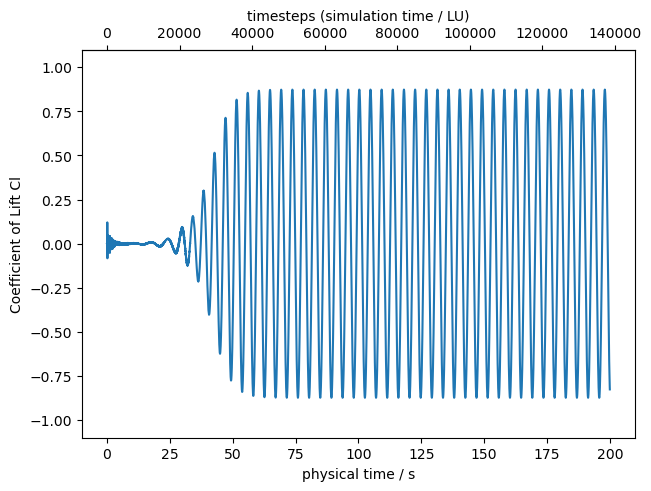

Cl_peaks: 
min -0.8734156449203951 
max 0.8734153766250834


In [18]:
### plot LIFT COEFFICIENT

lift_coefficient = np.array(Liftreport.out)
# print('  stepLU        ', 'timePU        ', 'Cl')
# print(lift_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(lift_coefficient[:,1],lift_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Lift Cl")
ax.set_ylim([-1.1,1.1])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/lift_coefficient.png")
    np.savetxt(output_path+dir_name+"/lift_coefficient.txt", lift_coefficient, header="stepLU  |  timePU  |  Cl  FROM str(timestamp)")
plt.show()

Cl_min = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].min()
Cl_max = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].max()

print("Cl_peaks: \nmin", Cl_min,"\nmax", Cl_max)

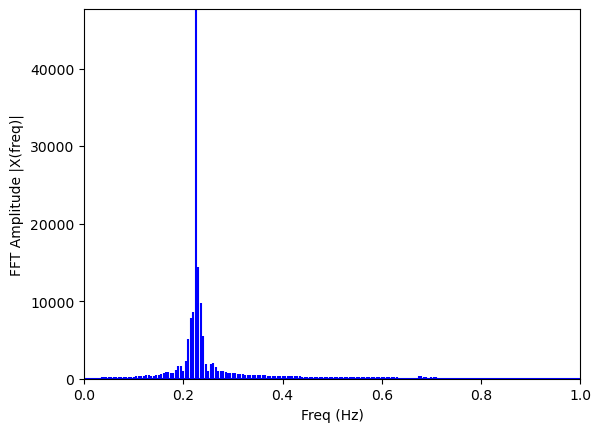

Frequency Peak: 0.22499848111889573 +- 0.0049999662470865715 Hz


In [19]:
### prototyped fft for frequency detection and calculation of strouhal-number
# ! Drag_frequency is 2* Strouhal-Freq. Lift-freq. is Strouhal-Freq.

try:
    X = np.fft.fft(lift_coefficient[:,2])   # fft result (amplitudes)
    N = len(X)  # number of freqs
    n = np.arange(N)   # freq index
    T = N*flow.units.convert_time_to_pu(1)   # total time measured (T_PU)
    freq = n/T   # frequencies (x-axis of spectrum)

    plt.figure
    plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")   # plot spectrum |X|(f)
    plt.xlabel("Freq (Hz)")
    plt.ylabel("FFT Amplitude |X(freq)|")
    plt.xlim(0,1)
    #print("max. Amplitude np.abx(X).max():", np.abs(X).max())   # for debugging
    plt.ylim(0,np.abs(X[:int(X.shape[0]*0.5)]).max())   # ylim, where highes peak is on left half of full spectrum

    if output_data:
        plt.savefig(output_path+dir_name+"/fft_Cl.png")
    plt.show()
    freq_res = freq[1]-freq[0]   # frequency-resolution
    X_abs = np.abs(X[:int(X.shape[0]*0.4)])   # get |X| Amplitude for left half of full spectrum
    freq_peak = freq[np.argmax(X_abs)]    # find frequency with highest amplitude
    print("Frequency Peak:", freq_peak, "+-", freq_res, "Hz")
    # f = Strouhal for St=f*D/U and D=U=1 in PU
except:
    print("Strouhal-calculation failed, check simulation data")
    freq_res=0
    freq_peak=0

In [20]:
# save notebook to simulation_output
if output_data:
    try:
        shutil.copy(str(os.getcwd())+"/cylinder2D_development_v2.ipynb",output_path+dir_name+"/script.ipynb")
    except:
        print("script could not be saved")
else:
    print("output_data-toggle is FALSE")

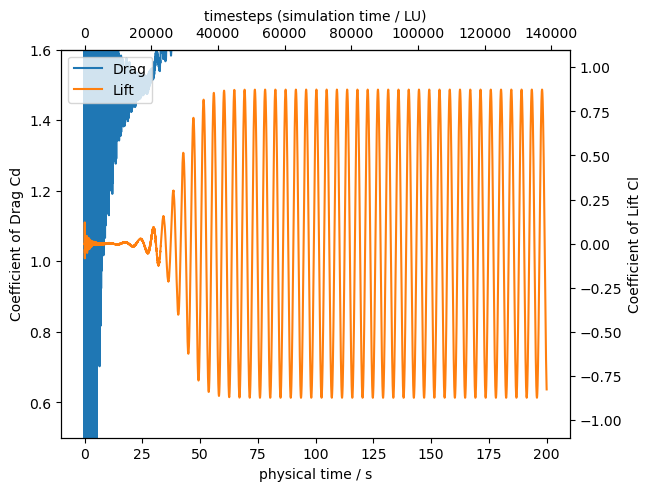

In [21]:
### plot Drag coefficient AND Lift Coefficient

#drag_coefficient = np.array(Dragreport.out)
#lift_coefficient = np.array(Liftreport.out)

fig, ax = plt.subplots(layout="constrained")
drag_ax = ax.plot(drag_coefficient[:,1],drag_coefficient[:,2], color="tab:blue", label="Drag")
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])

secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")

ax2 = ax.twinx()
lift_ax = ax2.plot(lift_coefficient[:,1],lift_coefficient[:,2], color="tab:orange", label="Lift")
ax2.set_ylabel("Coefficient of Lift Cl")
ax2.set_ylim([-1.1,1.1])


fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

if output_data:
    plt.savefig(output_path+dir_name+"/dragAndLift_coefficient.png")

plt.show()

In [22]:
### plotte Dichte (mean, max, min) im Fluid-Bereich

# plt.figure
# plt.plot(np.arange(len(DragObservable.rho_max_list)),DragObservable.rho_max_list)
# plt.plot(np.arange(len(DragObservable.rho_min_list)),DragObservable.rho_min_list)
# plt.plot(np.arange(len(DragObservable.rho_mean_list)),DragObservable.rho_mean_list)
# plt.legend(labels=["rho_max", "rho_min", "rho_mean"])
# plt.ylim([0.99,1.01])
# if output_data:
#     plt.savefig(output_path+dir_name+"/density.png")

In [23]:
### Analysis of GPU memory usage (tensors)

if output_data:
### cudas own memory summary
    print(torch.cuda.memory_summary(device="cuda:0"))
    ### CUDA-VRAM-summary:
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_memory_summary.txt", "a")
    output_file.write("DATA for "+timestamp+"\n\n")
    output_file.write(torch.cuda.memory_summary(device="cuda:0"))
    output_file.close()

### list present torch tensors:
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt", "a")
    total_bytes = 0
    import gc
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obj.data)):
                output_file.write("\n"+str(obj.size())+", "+str(obj.nelement()*obj.element_size()))
                total_bytes = total_bytes+obj.nelement()*obj.element_size()
        except:
            pass
    #output_file.write("\n\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

### count occurence of tensors in list of tensors:
    from collections import Counter
    my_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt","r")
    data=my_file.read()
    my_file.close()
    data_into_list=data.split("\n")
    c = Counter(data_into_list)
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_counted_tensors.txt", "a")
    for k,v in c.items():
        output_file.write("type,size,bytes: {}, number: {}\n".format(k,v) )
    output_file.write("\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1823 KB |    8075 KB |    6251 GB |    6251 GB |
|       from large pool |    1406 KB |    7032 KB |    4274 GB |    4274 GB |
|       from small pool |     417 KB |    1667 KB |    1976 GB |    1976 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1823 KB |    8075 KB |    6251 GB |    6251 GB |
|       from large pool |    1406 KB |    7032 KB |    4274 GB |

/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [24]:
# output data
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parms_stats_obs.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###   SIM-Parameters   ###")
    output_file.write("\nRe = "+str(re))
    output_file.write("\nn_steps = "+str(n_steps))
    output_file.write("\nT_target = "+str(flow.units.convert_time_to_pu(n_steps))+" seconds")
    output_file.write("\ngridpoints_per_diameter (gpd) = "+str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\nDpX (D/X) = " + str(domain_length_in_D))
    output_file.write("\nDpY (D/Y) = "+str(domain_height_in_D))
    if lattice.D == 3:
        output_file.write("\nDpZ (D/Z) = "+str(domain_width_in_D))
    output_file.write("\nshape_LU: "+ str(flow.shape))
    output_file.write(("\ntotal_number_of_gridpoints: "+str(lattice.rho(sim.f).numel())))
    output_file.write("\nbc_type = "+str(bc_type))
    output_file.write("\nlateral_walls = "+str(lateral_walls))
    output_file.write("\nstencil = "+str(stencil_choice))
    output_file.write("\ncollision = " + str(collision_choice))
    output_file.write("\n")
    output_file.write("\nMa = " + str(Ma))
    output_file.write("\ntau = " + str(tau))
    output_file.write("\ngrid_reynolds_number (Re_g) = " + str(re_g))
    output_file.write("\n")
    output_file.write("\nsetup_diameter_PU = " + str(setup_diameter))
    output_file.write("\nflow_velocity_PU = " + str(flow_velocity))
    output_file.write("\nu_init = " + str(u_init))
    output_file.write("\nperturb_init = " + str(perturb_init))
    output_file.write("\n")
    output_file.write("\noutput_vtk = " + str(output_vtk))
    output_file.write("\nvtk_fps = " + str(vtk_fps))

    output_file.write("\n\n###   SIM-STATS  ###")
    output_file.write("\nruntime = "+str(runtime)+ " seconds (="+str(runtime/60)+" minutes)")
    output_file.write("\nMLUPS = "+str(mlups))
    output_file.write("\n")
    output_file.write("\navg. Collision-Time [s] = " + str(c_time) + " (" + str(round(100 * c_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Streaming-Time [s] = " + str(s_time) + " (" + str(round(100 * s_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Boundary-Time  [s] = " + str(b_time) + " (" + str(round(100 * b_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Reporter-Time  [s] = " + str(r_time) + " (" + str(round(100 * r_time/sum_time, 2)) + " %)")
    output_file.write("\n")
    output_file.write("\nVRAM_current [MB] = " + str(torch.cuda.memory_allocated(lattice.device)/1024/1024))
    output_file.write("\nVRAM_peak [MB] = " + str(torch.cuda.max_memory_allocated(lattice.device)/1024/1024))

    output_file.write("\n\n###   OBSERVABLES   ###")
    output_file.write("\nCoefficient of drag between "+str(round(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1],2))+" s and "+str(round(drag_coefficient[int(drag_coefficient.shape[0]-1),1],2))+" s:")
    output_file.write("\nCd_mean, simple      = "+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\nCd_mean, peak_finder = "+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\nCd_min = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\nCd_max = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\nCoefficient of lift:")
    output_file.write("\nCl_min = "+str(Cl_min))
    output_file.write("\nCl_max = "+str(Cl_max))
    output_file.write("\n")
    output_file.write("\nStrouhal number:")
    output_file.write("\nSt +- df = "+str(freq_peak)+" +- "+str(freq_res)+" Hz")
    output_file.write("\n")
    output_file.close()


In [25]:
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parms_stats_obs_copyable.txt", "a")

    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###   Data:   ###")
    output_file.write("\nRe, n_steps, t_target(PU), GPD, DpX, DpY, (DpZ), shape_LU, gridpoints, bc_type, lateral_walls, stencil, collision, Ma, tau, Re_grid, setup_diameter_PU, flow_velocity_PU, u_init, perturb_init, output_vtk, vtk_fps, runtime, MLUPS, c_time, s_time, b_time, r_time, VRAM_current_MB, VRAM_peak_MB, periodic_start, Cd_mean, Cd_mean_pf, Cd_min, Cd_max, Cl_min, Cl_max, St, df")
    output_file.write("\n" + str(re))
    output_file.write("\n" + str(n_steps))
    output_file.write("\n" + str(flow.units.convert_time_to_pu(n_steps)))
    output_file.write("\n" + str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\n" + str(domain_length_in_D))
    output_file.write("\n" + str(domain_height_in_D))
    if lattice.D == 3:
        output_file.write("\n" + str(domain_width_in_D))
    output_file.write("\n" + str(flow.shape))
    output_file.write("\n" + str(lattice.rho(sim.f).numel()))
    output_file.write("\n"+str(bc_type))
    output_file.write("\n"+str(lateral_walls))
    output_file.write("\n"+str(stencil_choice))
    output_file.write("\n" + str(collision_choice))
    output_file.write("\n")
    output_file.write("\n" + str(Ma))
    output_file.write("\n" + str(tau))
    output_file.write("\n" + str(re_g))
    output_file.write("\n")
    output_file.write("\n" + str(setup_diameter))
    output_file.write("\n" + str(flow_velocity))
    output_file.write("\n" + str(u_init))
    output_file.write("\n" + str(perturb_init))
    output_file.write("\n")
    output_file.write("\n" + str(output_vtk))
    output_file.write("\n" + str(vtk_fps))
    output_file.write("\n")

    output_file.write("\n"+str(runtime))
    output_file.write("\n"+str(mlups))
    output_file.write("\n")
    output_file.write("\n" + str(c_time))
    output_file.write("\n" + str(s_time))
    output_file.write("\n" + str(b_time))
    output_file.write("\n" + str(r_time))
    output_file.write("\n")
    output_file.write("\n" + str(torch.cuda.memory_allocated(lattice.device)/1024/1024))
    output_file.write("\n" + str(torch.cuda.max_memory_allocated(lattice.device)/1024/1024))
    output_file.write("\n")

    output_file.write("\n" + str(periodic_start))
    output_file.write("\n"+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\n"+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\n"+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\n"+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\n"+str(Cl_min))
    output_file.write("\n"+str(Cl_max))
    output_file.write("\n")
    output_file.write("\n"+str(freq_peak))
    output_file.write("\n"+str(freq_res))
    output_file.write("\n")
    output_file.close()

In [13]:
print("current VRAM (MB): ", torch.cuda.memory_allocated(device="cuda:0")/1024/1024)
print("max. VRAM (MB): ", torch.cuda.max_memory_allocated(device="cuda:0")/1024/1024)

current VRAM (MB):  710.22216796875
max. VRAM (MB):  3155.32763671875
